In [1]:
import torch
from torch.nn import Module
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import pickle
import glob
import time

import matplotlib.pyplot as plt

In [2]:
targets_fp = sorted(glob.glob("../data/loc2vec_train_pt_tensors/targets/*.pt"))
contexts_fp = sorted(glob.glob("../data/loc2vec_train_pt_tensors/contexts/*.pt"))
labels_fp = sorted(glob.glob("../data/loc2vec_train_pt_tensors/labels/*.pt"))

In [13]:
with open("../models/tokenizers/decode_token_to_h3.pickle", "rb") as f:
    decode_dict = pickle.load(f)

In [14]:
vocab_size = len(decode_dict.keys())

In [15]:
print(vocab_size)

4047


In [16]:
class Loc2VecDataset(Dataset):
    def __init__(self, targets, contexts, labels):
        super().__init__()
        self.targets = targets
        self.contexts = contexts
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.targets[idx, :], self.contexts[idx, :], self.labels[idx, :]

In [17]:
class Loc2Vec(Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.target_embed = torch.nn.Embedding(vocab_size, embedding_size)
        self.context_embed = torch.nn.Embedding(vocab_size, embedding_size)
    def forward(self, target, context):
        target_embedding = self.target_embed(target)
        context_embedding = self.context_embed(context)
        dot_products = torch.bmm(target_embedding, context_embedding.view(context_embedding.shape[0], 
                                                                          context_embedding.shape[2], 
                                                                          context_embedding.shape[1]))
        dot_products = dot_products.reshape((dot_products.shape[0], 
                                             dot_products.shape[2]))
        return dot_products

In [23]:
model = Loc2Vec(vocab_size, 100)

loss_func = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 8

In [24]:
dataloaders = []
for t, c, l in zip(targets_fp, contexts_fp, labels_fp):
    t_tensor = torch.load(t)
    c_tensor = torch.load(c)
    l_tensor = torch.load(l)
    train_dataset = Loc2VecDataset(t_tensor, c_tensor, l_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=128)
    dataloaders.append(train_dataloader)

In [25]:
losses = []
times = []
for epoch in range(EPOCHS):
    epoch_start = time.time()
    batch_losses = []
    for dataloader in dataloaders:
        for target, context, label in dataloader:
            pred = model(target, context)
            loss = loss_func(pred, label.float())
            batch_losses.append(loss)

            #Set gradients to zero
            optimizer.zero_grad()
            #Compute gradients
            loss.backward()
            #Update parameters with gradients and LR
            optimizer.step()

    batch_loss = sum(batch_losses) / len(batch_losses)
    batch_loss = batch_loss.detach().item()
    losses.append(batch_loss)
    if epoch % 2 == 0:
        print(batch_loss)
    epoch_rt = time.time() - epoch_start
    times.append(epoch_rt)
    torch.save(model.state_dict(), f"../models/embeddings/epoch_chkpt/loc2vec_100k_epoch{epoch}_9_29")

0.0979195311665535
0.006339101120829582
0.0030422809068113565
0.0020846398547291756


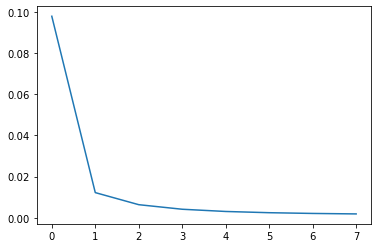

In [26]:
plt.plot(losses)

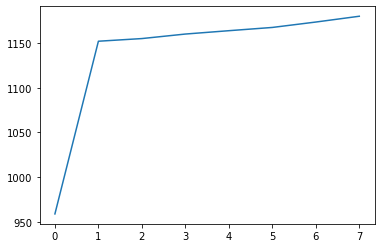

In [27]:
plt.plot(times)

In [28]:
torch.save(model.state_dict(), "../models/embeddings/loc2vec_100k_9_28")